In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm
import tensor_utils as utils
rng = np.random.default_rng(14159)
np.set_printoptions(legacy='1.25')

# Set parameters

In [2]:
# Define grid for epsilon values
N_points = 50
N_rep = 20
eps_r = np.linspace(1/N_points, 1, N_points)

# Tensor shape
n = np.array([100, 200, 700])//2
N = np.sum(n)
c = n/N
d = n.size

# Signal
beta = 2.5
x = [rng.standard_normal(n[ell]) for ell in range(d)]
x = [x[ell]/linalg.norm(x[ell]) for ell in range(d)]
P = beta*utils.outer(x)

setting = "$\\mathbf{{n}} = {{{}}}^\\top \\quad \\beta = {{{}}}$".format(list(n), beta)

# Computation alignments

In [3]:
def asymp(sigma, c, eps, delta=1e-6):
    # Compute asymptotic value of sigma and alignments
    # First iteration
    m, mm = utils.stieltjes_scalar(sigma, c, eps)
    q = 1-eps*(mm.real**2)/c
    sigma_m = 2*sigma
    sigma_p = eps*(beta*np.prod(q)-m.real)
    # Fixed-point
    while np.abs(sigma_p-sigma_m) > delta:
        m, mm = utils.stieltjes_scalar(sigma_p, c, eps)
        q = np.sqrt(1-eps*(mm.real**2)/c)
        sigma_m = sigma_p
        sigma_p = eps*(beta*np.prod(q)-m.real)
    if np.abs(utils.stieltjes_scalar(sigma_p, c, eps)[0].imag) > delta: # if not spike
        return np.nan, np.zeros_like(c)
    return sigma_p, q

In [4]:
align_est = np.zeros((N_points, N_rep, d))
align_pred = np.zeros((N_points, d))
for i, eps in enumerate(tqdm(eps_r)):
    for rep in range(N_rep):
        W = rng.standard_normal(n)
        T = P+W/np.sqrt(N)
        B = rng.binomial(1, eps, size=n)
        sigma, u = utils.CPD1(T*B)
        for ell in range(d):
            align_est[i, rep, ell] = np.abs(x[ell]@u[ell])
    align_pred[i] = asymp(sigma, c, eps)[1]
align_mean = np.mean(align_est, axis=1)
align_std = np.std(align_est, axis=1)

100%|██████████| 50/50 [08:18<00:00,  9.97s/it]


# Plots

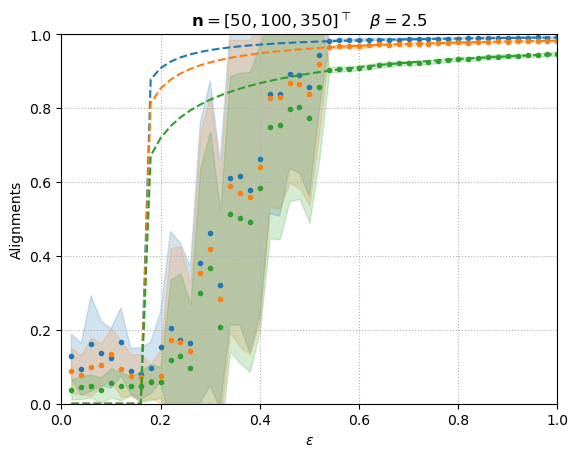

In [ ]:
for ell in range(d):
    color='C'+str(ell)
    plt.plot(eps_r, align_mean[:, ell], ls='', marker='.', color=color)
    plt.fill_between(eps_r, align_mean[:, ell]-align_std[:, ell], align_mean[:, ell]+align_std[:, ell], alpha=.2, color=color)
    plt.plot(eps_r, align_pred[:, ell], ls='--', color=color)
plt.grid(ls=':')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$\\varepsilon$")
plt.ylabel("Alignments")
plt.title(setting)
plt.show()